## Importing the necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

## Getting the path of the training and testing data of the brain tumor dataset

In [2]:
dataset_directory_location = 'cell_images'

In [3]:
os.listdir(dataset_directory_location)

['test', 'train']

In [4]:
train_dataset_location = os.path.join(dataset_directory_location, 'train')
test_dataset_location = os.path.join(dataset_directory_location, 'test')

In [5]:
os.listdir(train_dataset_location)

['parasitized', 'uninfected']

In [6]:
os.listdir(test_dataset_location)

['parasitized', 'uninfected']

## Viewing a brain image

In [7]:
cell_image_sample = os.path.join(train_dataset_location, 'Parasitized')

In [8]:
os.listdir(cell_image_sample)[:1]

['C33P1thinF_IMG_20150619_114756a_cell_179.png']

In [9]:
cell_image_sample_read = imread(os.path.join(cell_image_sample, 'C33P1thinF_IMG_20150619_114756a_cell_179.png'))

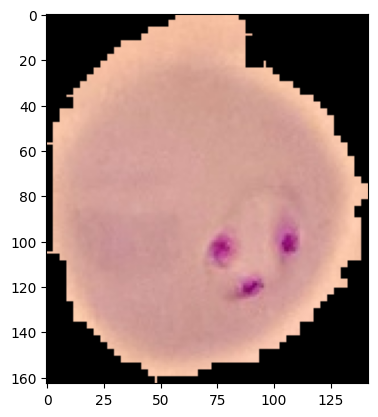

In [10]:
plt.imshow(cell_image_sample_read)

In [11]:
cell_image_sample_read.shape 

(163, 142, 3)

## Defining the correct shape of the image

In [12]:
correct_image_shape = (224, 224, 3)

## Defining the ImageGenerator and performing Data Augmentation

In [13]:
image_gen = ImageDataGenerator(rotation_range=20, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               shear_range=0.1, 
                               zoom_range=0.1, 
                               horizontal_flip=True, 
                               fill_mode='nearest',
                               preprocessing_function=preprocess_input)

In [14]:
train_image_gen = image_gen.flow_from_directory(train_dataset_location, 
                                                target_size=correct_image_shape[:2], 
                                                color_mode='rgb', 
                                                batch_size=16, 
                                                class_mode='binary')

test_image_gen = image_gen.flow_from_directory(test_dataset_location, 
                                                target_size=correct_image_shape[:2], 
                                                color_mode='rgb', 
                                                batch_size=16, 
                                                class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Defining the early stop

In [15]:
early_stop_loss = EarlyStopping(monitor='loss', patience=2)
early_stop_val_loss = EarlyStopping(monitor='val_loss', patience=2)

## Creating and training the model

In [16]:
model = Sequential()

In [17]:
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=correct_image_shape)

In [18]:
resnet101_model.trainable = False

In [19]:
model.add(resnet101_model)


model.add(Flatten())


model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0

In [21]:
model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

In [22]:
model.fit(train_image_gen, validation_data=test_image_gen, epochs=30, callbacks=[early_stop_loss, early_stop_val_loss])

Epoch 1/30
625/625 [==============================] - 207s 287ms/step - loss: 0.4336 - accuracy: 0.8056 - val_loss: 0.2735 - val_accuracy: 0.8920
Epoch 2/30
625/625 [==============================] - 166s 266ms/step - loss: 0.3239 - accuracy: 0.8633 - val_loss: 0.2353 - val_accuracy: 0.9125
Epoch 3/30
625/625 [==============================] - 166s 266ms/step - loss: 0.2904 - accuracy: 0.8795 - val_loss: 0.2190 - val_accuracy: 0.9090
Epoch 4/30
625/625 [==============================] - 166s 266ms/step - loss: 0.2760 - accuracy: 0.8857 - val_loss: 0.2158 - val_accuracy: 0.9170
Epoch 5/30
625/625 [==============================] - 164s 263ms/step - loss: 0.2644 - accuracy: 0.8953 - val_loss: 0.1973 - val_accuracy: 0.9220
Epoch 6/30
625/625 [==============================] - 167s 267ms/step - loss: 0.2548 - accuracy: 0.8983 - val_loss: 0.2075 - val_accuracy: 0.9195
Epoch 7/30
625/625 [==============================] - 165s 263ms/step - loss: 0.2552 - accuracy: 0.8984 - val_loss: 0.1959 -

In [23]:
history_df = pd.DataFrame(model.history.history)

<Axes: >

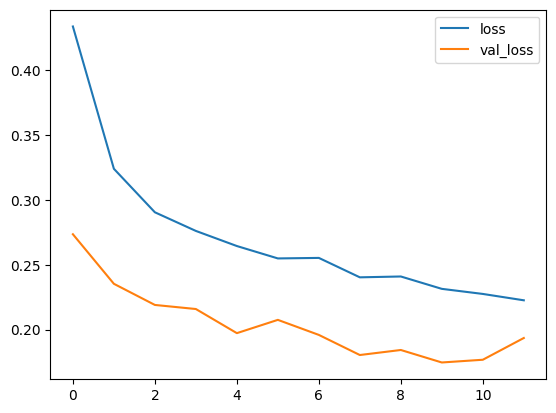

In [24]:
history_df[['loss', 'val_loss']].plot()

<Axes: >

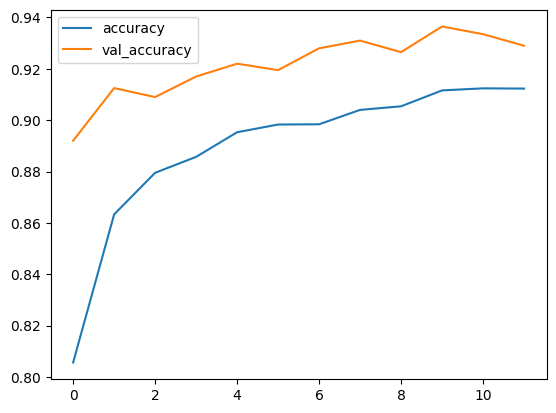

In [25]:
history_df[['accuracy', 'val_accuracy']].plot()

## Evaluating the model

In [26]:
model.evaluate(train_image_gen)[1]

625/625 [==============================] - 137s 219ms/step - loss: 0.1546 - accuracy: 0.9433


0.9433000087738037

In [27]:
model.evaluate(test_image_gen)[1]

125/125 [==============================] - 28s 220ms/step - loss: 0.1905 - accuracy: 0.9305


0.9304999709129333

## Predicting on a sample image

In [28]:
sample_img_load = image.load_img('./cell_images/test/parasitized/C100P61ThinF_IMG_20150918_145609_cell_149.png', target_size=correct_image_shape)

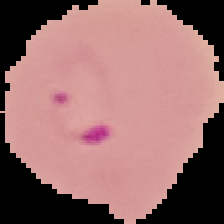

In [29]:
sample_img_load

In [30]:
sample_img_to_arr = image.img_to_array(sample_img_load) 

In [31]:
sample_img_to_arr = image.img_to_array(sample_img_load) / 255

In [32]:
sample_img_to_arr_expand_dim = np.expand_dims(sample_img_to_arr, 0) 

In [33]:
prediction = (model.predict(sample_img_to_arr_expand_dim) > 0.5).astype('int32')

1/1 [==============================] - 3s 3s/step


In [34]:
class_names = ['parasitized', 'uninfected']

In [35]:
pred_final_result = class_names[prediction[0][0]]

In [36]:
pred_final_result

'parasitized'

## Save the model

In [37]:
save_model(model, 'resnet101_model')

INFO:tensorflow:Assets written to: resnet101_model\assets


INFO:tensorflow:Assets written to: resnet101_model\assets
